In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

## 1. The Factors

In [16]:
df = pd.read_excel("dfa_analysis_data.xlsx", sheet_name="factors")
df.set_index("Date", inplace=True)
df.drop(columns=["RF"], inplace=True)

In [ ]:
df_beg_1980 = df.loc[:"1980"]
df_beg_1980_result = pd.DataFrame([df_beg_1980.mean(axis=0) * 12, df_beg_1980.std(axis=0) * np.sqrt(12), 
              df_beg_1980.mean(axis=0) * 12 /df_beg_1980.std(axis=0) * np.sqrt(12),
              df_beg_1980.quantile(0.05)], index = ['mean', 'vol', 'sharpe', 'VaR(0.05)']).T
df_beg_1980_result

,mean,vol,sharpe,VaR(0.05)
Mkt-RF,0.080958,0.204988,4.739260,-0.084090
SMB,0.033914,0.114277,3.561230,-0.041875
HML,0.050321,0.134228,4.498717,-0.044245


In [18]:
df_1981_2001 = df.loc["1981":"2001"]
df_1981_2001_result = pd.DataFrame([df_1981_2001.mean(axis=0) * 12, df_1981_2001.std(axis=0) * np.sqrt(12), 
              df_1981_2001.mean(axis=0) * 12 /df_1981_2001.std(axis=0) * np.sqrt(12),
              df_1981_2001.quantile(0.05)], index = ['mean', 'vol', 'sharpe', 'VaR(0.05)']).T
df_1981_2001_result

,mean,vol,sharpe,VaR(0.05)
Mkt-RF,0.077852,0.157183,5.943573,-0.064135
SMB,-0.002014,0.117260,-0.206135,-0.045880
HML,0.064557,0.109863,7.051358,-0.041640


In [20]:
df_2002_end = df.loc["2002":]
df_2002_end_result = pd.DataFrame([df_2002_end.mean(axis=0) * 12, df_2002_end.std(axis=0) * np.sqrt(12), 
              df_2002_end.mean(axis=0) * 12 /df_2002_end.std(axis=0) * np.sqrt(12),
              df_2002_end.quantile(0.05)], index = ['mean', 'vol', 'sharpe', 'VaR(0.05)']).T
df_2002_end_result

,mean,vol,sharpe,VaR(0.05)
Mkt-RF,0.091306,0.153529,7.136532,-0.077265
SMB,0.007931,0.088448,1.076025,-0.039195
HML,0.001204,0.106442,0.135761,-0.041485


## 2. 

- Market Risk Free Rate has a positive return in all subsamples, the value factor has a positive return in all subsamples, but the size factor does not have a positive return in each subsample
- The premium to the size factor decreased after 1980, before 1980 the average return in the size factor is around 3%, while after 1981 it became negative, and eventually returned to around 0% after 2002. 
- The premium to the value factor decreased during 1990s.
- The premium to the market factor remains strong at 9% with sharpe of 7, but the size and value factor has reduced in size.

## 3. Correlation

<Axes: >

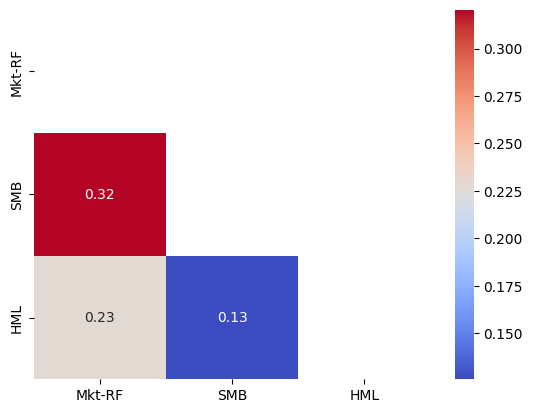

In [21]:
import seaborn as sn

factor_corr = df.corr()

mask = np.triu(np.ones_like(factor_corr, dtype=bool))

sn.heatmap(factor_corr, mask = mask, annot=True, cmap="coolwarm")

- The construction method does indeed succeed in keeping the correlations small

In [23]:
print(df_beg_1980.corr())
print(df_1981_2001.corr())
print(df_2002_end.corr())

          Mkt-RF       SMB       HML
Mkt-RF  1.000000  0.374234  0.442341
SMB     0.374234  1.000000  0.313397
HML     0.442341  0.313397  1.000000
          Mkt-RF       SMB       HML
Mkt-RF  1.000000  0.158652 -0.529912
SMB     0.158652  1.000000 -0.445451
HML    -0.529912 -0.445451  1.000000
          Mkt-RF       SMB       HML
Mkt-RF  1.000000  0.316034  0.109671
SMB     0.316034  1.000000  0.116227
HML     0.109671  0.116227  1.000000


- Overall, the construction method succeeds in keeping correlations small across multiple subsamples and across the entire sample. 

## 2.4 Cumulative Returns

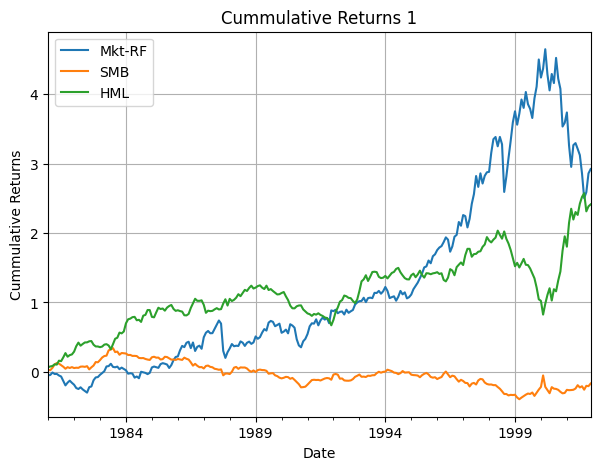

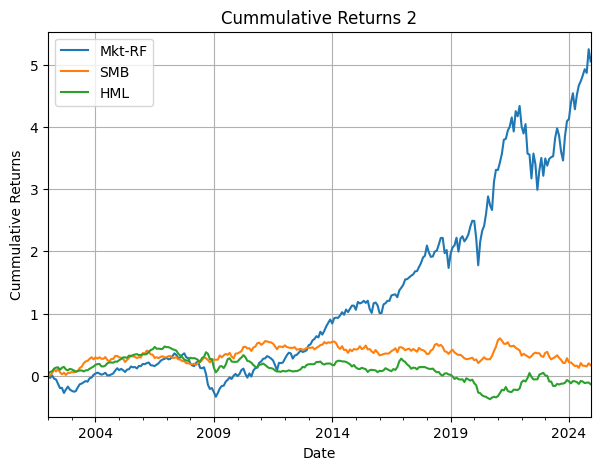

In [27]:
from typing import Union, List

def calc_cummulative_returns(
    returns: Union[pd.DataFrame, pd.Series],
    return_plot: bool = True,
    fig_size: tuple = (7, 5),
    return_series: bool = False,
    name: str = None,
    timeframes: Union[None, dict] = None,
):
    """
    Calculates cumulative returns from a time series of returns.

    Parameters:
    returns (pd.DataFrame or pd.Series): Time series of returns.
    return_plot (bool, default=True): If True, plots the cumulative returns.
    fig_size (tuple, default=(7, 5)): Size of the plot for cumulative returns.
    return_series (bool, default=False): If True, returns the cumulative returns as a DataFrame.
    name (str, default=None): Name for the title of the plot or the cumulative return series.
    timeframes (dict or None, default=None): Dictionary of timeframes to calculate cumulative returns for each period.

    Returns:
    pd.DataFrame or None: Returns cumulative returns DataFrame if `return_series` is True.
    """
    if timeframes is not None:
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns for {name} timeframe')
            calc_cummulative_returns(
                timeframe_returns,
                return_plot=True,
                fig_size=fig_size,
                return_series=False,
                name=name,
                timeframes=None
            )
        return
    returns = returns.copy()
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()
    returns = returns.apply(lambda x: x.astype(float))
    returns = returns.apply(lambda x: x + 1)
    returns = returns.cumprod()
    returns = returns.apply(lambda x: x - 1)
    title = f'Cummulative Returns {name}' if name else 'Cummulative Returns'
    if return_plot:
        returns.plot(
            title=title,
            figsize=fig_size,
            grid=True,
            xlabel='Date',
            ylabel='Cummulative Returns'
        )
    if return_series:
        return returns
    

calc_cummulative_returns(returns=df, return_plot=True, timeframes={1:["1981","2001"], 2:["2002","2024"]})

## 2.5
- It appears that value and market were valuable in 1981-2001, and post-2001, only market factor is valuable.

## 2. CAPM

In [31]:
df = pd.read_excel("dfa_analysis_data.xlsx", sheet_name = "portfolios (total returns)")
df = df[df["Date"] > "1981"]
df.set_index("Date", inplace=True)
df.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.043849,-0.003493,0.014112,0.016792,0.032552,-0.047463,-0.007454,0.000284,0.018336,0.031017,...,-0.068260,-0.034515,-0.003771,0.005511,0.014298,-0.061380,-0.073114,-0.064157,-0.000683,0.022764
1981-02-28,-0.034100,-0.012040,0.012525,0.020378,0.023178,-0.003460,0.018115,0.025610,0.032927,0.038680,...,0.013817,0.024142,0.044923,0.016688,0.038189,0.032819,0.020830,-0.006348,0.031139,-0.004509
1981-03-31,0.073664,0.103421,0.087605,0.090041,0.072482,0.080794,0.083187,0.076754,0.076075,0.075550,...,0.089507,0.067198,0.084585,0.082615,0.077287,0.032784,0.036496,0.004141,0.034018,0.081981
1981-04-30,0.027871,0.045343,0.035393,0.046487,0.054125,0.016258,0.035803,0.035347,0.036961,0.040233,...,0.000344,-0.008426,0.006191,-0.002428,0.017040,-0.030450,-0.047814,-0.026559,0.021697,-0.029724
1981-05-31,0.050053,0.052081,0.040379,0.025547,0.026729,0.061760,0.018737,0.031615,0.002218,0.025213,...,0.033858,0.020610,0.019832,0.008182,0.033651,0.015915,-0.021939,-0.019354,0.037471,0.007540


In [32]:
risk_free_rate = pd.read_excel("dfa_analysis_data.xlsx", sheet_name = "factors")
risk_free_rate = risk_free_rate[risk_free_rate['Date'] > "1981"]
risk_free_rate.set_index("Date", inplace=True)
spy = risk_free_rate[["Mkt-RF"]]
rf = risk_free_rate[["RF"]]
rf

,RF
Date,
1981-01-31,0.0104
1981-02-28,0.0107
1981-03-31,0.0121
1981-04-30,0.0108
1981-05-31,0.0115
...,...
2025-04-30,0.0035
2025-05-31,0.0038
2025-06-30,0.0034


In [6]:
xr = df.sub(rf['RF'], axis=0)
xr

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.054249,-0.013893,0.003712,0.006392,0.022152,-0.057863,-0.017854,-0.010116,0.007936,0.020617,...,-0.078660,-0.044915,-0.014171,-0.004889,0.003898,-0.071780,-0.083514,-0.074557,-0.011083,0.012364
1981-02-28,-0.044800,-0.022740,0.001825,0.009678,0.012478,-0.014160,0.007415,0.014910,0.022227,0.027980,...,0.003117,0.013442,0.034223,0.005988,0.027489,0.022119,0.010130,-0.017048,0.020439,-0.015209
1981-03-31,0.061564,0.091321,0.075505,0.077941,0.060382,0.068694,0.071087,0.064654,0.063975,0.063450,...,0.077407,0.055098,0.072485,0.070515,0.065187,0.020684,0.024396,-0.007959,0.021918,0.069881
1981-04-30,0.017071,0.034543,0.024593,0.035687,0.043325,0.005458,0.025003,0.024547,0.026161,0.029433,...,-0.010456,-0.019226,-0.004609,-0.013228,0.006240,-0.041250,-0.058614,-0.037359,0.010897,-0.040524
1981-05-31,0.038553,0.040581,0.028879,0.014047,0.015229,0.050260,0.007237,0.020115,-0.009282,0.013713,...,0.022358,0.009110,0.008332,-0.003318,0.022151,0.004415,-0.033439,-0.030854,0.025971,-0.003960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.004568,0.013403,0.005444,-0.009842,-0.028751,0.002469,-0.012547,-0.028043,-0.034868,-0.067272,...,-0.012266,-0.016199,-0.023646,-0.042776,-0.076168,0.010606,-0.033629,-0.077367,-0.016972,-0.031441
2025-05-31,0.104649,0.053824,0.049631,0.038679,0.053372,0.040805,0.047000,0.065733,0.046892,0.054768,...,0.058777,0.046422,0.031553,0.077375,0.062026,0.074277,0.057496,0.014607,0.022356,0.061884
2025-06-30,0.135179,0.055405,0.083003,0.043425,0.051947,0.058885,0.062943,0.070162,0.052760,0.046904,...,0.016951,0.039792,0.020775,0.070415,0.054624,0.051879,0.059051,0.044005,0.033024,0.066709


## 2 CAPM 

In [14]:
betas = []

alphas = []

for equity in xr.columns:

    model = LinearRegression()

    model.fit(X=spy, y=xr[[equity]])

    beta = model.coef_[0][0]

    betas.append(float(beta))

    alpha = model.intercept_[0]

    alphas.append(alpha)


betas = pd.Series(betas, index=xr.columns)
betas.name = "beta"

alphas = pd.Series(alphas, index=xr.columns)
alphas.name = "alpha"


result = pd.concat([betas, alphas], axis=1)

result


,beta,alpha
SMALL LoBM,1.358486,-0.008645
ME1 BM2,1.165759,-0.000886
ME1 BM3,1.049509,0.000087
ME1 BM4,0.977337,0.002457
SMALL HiBM,0.993918,0.003571
ME2 BM1,1.334065,-0.004371
ME2 BM2,1.138954,0.000131
ME2 BM3,1.035676,0.001429
ME2 BM4,0.976453,0.002091
ME2 BM5,1.110819,0.001566


## 3 Cross Sectional Estimation

$\$

In [18]:
mean_excess_return = xr.mean(axis=0)
mean_excess_return.name = "mean_excess_return"
mean_excess_return = pd.DataFrame(mean_excess_return)
mean_excess_return

,mean_excess_return
SMALL LoBM,0.000975
ME1 BM2,0.007370
ME1 BM3,0.007519
ME1 BM4,0.009378
SMALL HiBM,0.010610
ME2 BM1,0.005077
ME2 BM2,0.008197
ME2 BM3,0.008763
ME2 BM4,0.009006
ME2 BM5,0.009433


In [22]:
cross_section_model = LinearRegression()

cross_section_model.fit(X=result[["beta"]], y=mean_excess_return[["mean_excess_return"]])

lam = cross_section_model.coef_[0][0]
intercept = cross_section_model.intercept_[0]

r_square = cross_section_model.score(result[["beta"]], mean_excess_return[["mean_excess_return"]])

lam, intercept, r_square

(np.float64(-0.008826013628764744),
 np.float64(0.017153471154950615),
 0.3131534368296671)